# Steps to conduct

1. Setup (Databricks/AWS/GitHub)     ---------------------------                       <-- We are currently here!
2. EDA (within Databricks per PySpark/SQL)
3. Feature Selection (Databricks)
4. Write to S3
5. ML case on AWS Sagemaker (model, scores, etc.)
6. Deployment on AWS Sagemaker
6. Create presentation
7. (20:80 or optional task)

# Import Data

In [0]:
# connect so s3 bucket
# get credentials
import os

ACCESS_KEY = os.getenv("AWS_ACCESS_KEY")
SECRET_KEY = os.getenv("AWS_SECRET_KEY")
ENCODED_SECRET_KEY = SECRET_KEY.replace("/", "%2F")
AWS_BUCKET_NAME = "aida-project"
MOUNT_NAME = "data"

# mount data
dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY, ENCODED_SECRET_KEY, AWS_BUCKET_NAME), "/mnt/%s" % MOUNT_NAME)
display(dbutils.fs.ls("/mnt/%s" % MOUNT_NAME))

path,name,size
dbfs:/mnt/data/TSV/,TSV/,0


In [0]:
display(dbutils.fs.ls("/mnt/%s/TSV" % MOUNT_NAME))

path,name,size
dbfs:/mnt/data/TSV/name.basics.tsv,name.basics.tsv,579976550
dbfs:/mnt/data/TSV/title.akas.tsv,title.akas.tsv,969441812
dbfs:/mnt/data/TSV/title.basics.tsv,title.basics.tsv,537519832
dbfs:/mnt/data/TSV/title.principals.tsv,title.principals.tsv,1622240736
dbfs:/mnt/data/TSV/title.ratings.tsv,title.ratings.tsv,16907124


In [0]:
df_names = spark.read.load("dbfs:/mnt/data/TSV/name.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_akas = spark.read.load("dbfs:/mnt/data/TSV/title.akas.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_basics = spark.read.load("dbfs:/mnt/data/TSV/title.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_principals = spark.read.load("dbfs:/mnt/data/TSV/title.principals.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")
df_ratings = spark.read.load("dbfs:/mnt/data/TSV/title.ratings.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")

In [0]:
list_dfs = [df_names, df_akas, df_basics, df_principals, df_ratings]

for df in list_dfs:
  df.printSchema()

root
-- nconst: string (nullable = true)
-- primaryName: string (nullable = true)
-- birthYear: string (nullable = true)
-- deathYear: string (nullable = true)
-- primaryProfession: string (nullable = true)
-- knownForTitles: string (nullable = true)

root
-- titleId: string (nullable = true)
-- ordering: integer (nullable = true)
-- title: string (nullable = true)
-- region: string (nullable = true)
-- language: string (nullable = true)
-- types: string (nullable = true)
-- attributes: string (nullable = true)
-- isOriginalTitle: string (nullable = true)

root
-- tconst: string (nullable = true)
-- titleType: string (nullable = true)
-- primaryTitle: string (nullable = true)
-- originalTitle: string (nullable = true)
-- isAdult: integer (nullable = true)
-- startYear: string (nullable = true)
-- endYear: string (nullable = true)
-- runtimeMinutes: string (nullable = true)
-- genres: string (nullable = true)

root
-- tconst: string (nullable = true)
-- ordering: integer (nullable = true)
-- nconst: string (nullable = true)
-- category: string (nullable = true)
-- job: string (nullable = true)
-- characters: string (nullable = true)

root
-- tconst: string (nullable = true)
-- averageRating: double (nullable = true)
-- numVotes: integer (nullable = true)

# EDA

## Possible list of questions (non-exhaustive):
1. What is the range of our ratings (inlcuding distribution)? --------------------------------------- DONE
2. How many votes does a movie have on average? (Box-Plot)
3. What timeframe does our dataset span? (e.g. oldest and newest movie)
4. Who are the most popular actors and directors?
5. What genres are represented the most?
6. Distribution of films / series / shows?
    ----> Focus on movies!
7. What genres are in the dataset?
8. Which genres have the highest rating?
9. Which actors play in the high rated films?
10. In which countries were the most high-rated films made and when?
11. Dependence on high rated film:
    - Country of origin ---> Actor?
    - Genre -> Actor
    - Year of creation -> Actor -> Genre
12. Which parameters go into the rating?

.....

## Imports and Functions

In [0]:
from pyspark.sql.functions import mean as _mean, \
                                  min as _min, \
                                  max as _max, \
                                  count as _count, \
                                  stddev as _stddev, col

import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [0]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

In [0]:
# https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.histogram

def viz_histogram(dataframe, column, buckets):
  bins, counts = dataframe.select(column).rdd.flatMap(lambda x: x).histogram(buckets)
  plt.hist(bins[:-1], bins=bins, weights=counts)
  plt.title(f'Histogram of {column}')
  
  
def show_quantiles(dataframe, list_columns, percentiles):
  df_quantile = spark.createDataFrame(
      zip(percentiles, *df.approxQuantile(columns, percentiles, 0.1)), 
      ["Pecentile"] + columns
  )
  df_quantile.show()
  
  return df_quantile

## What is the range of our ratings (inlcuding distribution)

In [0]:
stats_ratings = df_ratings.select(
    _mean(col('averageRating')).alias('mean'),
    _min(col('averageRating')).alias('min'),
    _max(col('averageRating')).alias('max'),
    _stddev(col('averageRating')).alias('std')).collect()

min_ratings = stats_ratings[0]['min']
mean_ratings = stats_ratings[0]['mean']
max_ratings = stats_ratings[0]['max']
std_ratings = stats_ratings[0]['std']

stats_ratings

Out[61]: [Row(mean=6.886222569255395, min=1.0, max=10.0, std=1.4002965174441464)]

In [0]:
df_ratings.describe().show()

+-------+---------+------------------+------------------+
summary| tconst| averageRating| numVotes|
+-------+---------+------------------+------------------+
 count| 993821| 993821| 993821|
 mean| null| 6.886222569255395| 955.4982275480193|
 stddev| null|1.4002965174441464|15656.839581234926|
 min|tt0000001| 1.0| 5|
 max|tt9916778| 10.0| 2160364|
+-------+---------+------------------+------------------+

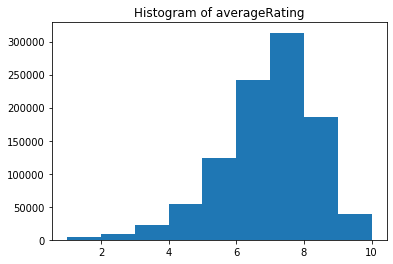

In [0]:
viz_histogram(df_ratings, 'averageRating', 9)

Our ratings range from **1** to **10**. The mean rating is **6.89** (maybe people are a little bit kinder than expected), with a standard deviation of roughly **1.40**. We have roughly **1 million** entries.

## How many votes does a movie have on average? (Box-Plot)

In [0]:
df_ratings.groupBy('tconst').mean('numVotes').describe().show()

+-------+---------+------------------+
summary| tconst| avg(numVotes)|
+-------+---------+------------------+
 count| 993821| 993821|
 mean| null| 955.4982275480193|
 stddev| null|15656.839581234844|
 min|tt0000001| 5.0|
 max|tt9916778| 2160364.0|
+-------+---------+------------------+

In [0]:
quantiles_votes = show_quantiles(df_ratings, 'numVotes', percentiles)

+---------+---------+
Pecentile| numVotes|
+---------+---------+
 0.1| 5.0|
 0.25| 8.0|
 0.5| 19.0|
 0.75| 74.0|
 0.9|2160364.0|
+---------+---------+

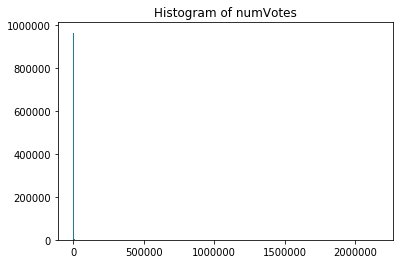

In [0]:
viz_histogram(df_ratings, 'numVotes', 1000)

# Feature Selection & Data Cleaning

# Write to S3

In [0]:
# TO DEFINE SHAPE OF TARGET DATASET

# id, rating, [list of features]

# sample of target dataset (e.g. 20%) write to s3

df_final.write('s3')

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3321533958678319> in <module> 
 5 # sample of target dataset (e.g. 20%) write to s3 
 6 
 ----> 7 df_final . write ( 's3' ) 

 NameError : name 'df_final' is not defined

In [0]:
#Import of the dataset

df_basics = spark.read.load("dbfs:/mnt/data/TSV/title.basics.tsv",
                           format="csv", sep="\t", inferSchema="true", header="true")




In [0]:
# What kind of data are in the columns
df_basics.printSchema()

root
-- tconst: string (nullable = true)
-- titleType: string (nullable = true)
-- primaryTitle: string (nullable = true)
-- originalTitle: string (nullable = true)
-- isAdult: integer (nullable = true)
-- startYear: string (nullable = true)
-- endYear: string (nullable = true)
-- runtimeMinutes: string (nullable = true)
-- genres: string (nullable = true)

Only 'isAdult' is an integer. What is the range or which values are available? What means nullable=True

In [0]:
df_basics.show()

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
 tconst|titleType| primaryTitle| originalTitle|isAdult|startYear|endYear|runtimeMinutes| genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
tt0000001| short| Carmencita| Carmencita| 0| 1894| \N| 1| Documentary,Short|
tt0000002| short|Le clown et ses c...|Le clown et ses c...| 0| 1892| \N| 5| Animation,Short|
tt0000003| short| Pauvre Pierrot| Pauvre Pierrot| 0| 1892| \N| 4|Animation,Comedy,...|
tt0000004| short| Un bon bock| Un bon bock| 0| 1892| \N| \N| Animation,Short|
tt0000005| short| Blacksmith Scene| Blacksmith Scene| 0| 1893| \N| 1| Comedy,Short|
tt0000006| short| Chinese Opium Den| Chinese Opium Den| 0| 1894| \N| 1| Short|
tt0000007| short|Corbett and Court...|Corbett and Court...| 0| 1894| \N| 1| Short,Sport|
tt0000008| short|Edison Kinetoscop...|Edison Kinetoscop...| 0| 1894| \N| 1| Documentary,Short|
tt0000009| movie| Miss Jerry| Miss Jerry| 0| 1894| \N| 45| Romance|
tt0000010| short| Exiting the Factory|La sortie de l'us...| 0| 1895| \N| 1| Documentary,Short|
tt0000011| short|Akrobatisches Pot...|Akrobatisches Pot...| 0| 1895| \N| 1| Documentary,Short|
tt0000012| short|The Arrival of a ...|L'arrivée d'un tr...| 0| 1896| \N| 1|Action,Documentar...|
tt0000013| short|The Photographica...|Neuville-sur-Saôn...| 0| 1895| \N| 1| Documentary,Short|
tt0000014| short|The Sprinkler Spr...| L'arroseur arrosé| 0| 1895| \N| 1| Comedy,Short|
tt0000015| short| Autour d'une cabine| Autour d'une cabine| 0| 1894| \N| 2| Animation,Short|
tt0000016| short|Barque sortant du...|Barque sortant du...| 0| 1895| \N| 1| Documentary,Short|
tt0000017| short|Italienischer Bau...|Italienischer Bau...| 0| 1895| \N| 1| Documentary,Short|
tt0000018| short|Das boxende Känguruh|Das boxende Känguruh| 0| 1895| \N| 1| Short|
tt0000019| short| The Clown Barber| The Clown Barber| 0| 1898| \N| \N| Comedy,Short|
tt0000020| short| The Derby 1895| The Derby 1895| 0| 1895| \N| 1|Documentary,Short...|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
only showing top 20 rows

What is the difference between titleTyp and genres?

In [0]:
display(df_basics)

tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short"
tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
tt0000010,short,Exiting the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


In [0]:
df_basics.describe()

Out[31]: DataFrame[summary: string, tconst: string, titleType: string, primaryTitle: string, originalTitle: string, isAdult: string, startYear: string, endYear: string, runtimeMinutes: string, genres: string]

In [0]:
display(df_basics.describe())

summary,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
count,6326545,6326545,6326545,6326545,6326545,6326545,6326545,6326545,6326535
mean,null,null,NaN,NaN,0.033084724758932406,2001.4857464536149,2001.6832648116879,45.00799321813517,null
stddev,null,null,NaN,NaN,2.536020251863344,21.183997012090863,18.883630674696988,76.33630531590723,null
min,tt0000001,movie,!Next?,!Next?,0,1874,1924,0,Action
max,tt9916880,videoGame,Šiška Deluxe,üç,2019,\N,\N,\N,\N


In [0]:
# GroupBy the titleTyp and count the sum

groupBy_output = df_basics.groupBy("titleType").count()
display(groupBy_output)

titleType,count
tvSeries,174601
tvMiniSeries,28413
tvMovie,120424
tvEpisode,4445415
movie,536248
tvSpecial,26137
video,247411
videoGame,24550
tvShort,11569
short,711777


In [0]:
groupBy_output = df_basics.groupBy("titleType").count()
display(groupBy_output)

titleType,count
tvSeries,174601
tvMiniSeries,28413
tvMovie,120424
tvEpisode,4445415
movie,536248
tvSpecial,26137
video,247411
videoGame,24550
tvShort,11569
short,711777


In [0]:
# GroupBy the genres and count the sum

groupBy_output = df_basics.groupBy("genres").count()
display(groupBy_output)

genres,count
"Comedy,Sport",2470
"Action,War,Western",5
"Action,Adventure,Fantasy",4789
"Drama,Romance,Talk-Show",1
"Documentary,Drama,Fantasy",80
"Adult,Comedy,Musical",11
"Crime,Horror,Short",311
"Adult,Horror,Sci-Fi",4
"Animation,Sci-Fi,War",64
"Documentary,News,Reality-TV",291
